In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [6]:
data = pd.read_csv('Landslide Civildf_new.csv')
data.head()

,Unnamed: 0,Timestamp,Rainfall,Water level,Inc30mup,Inc 30m down,Inc 20m up,Inc 20m down,Inc 10m up,Inc 10m down,1st Tensiometer,2nd Tensiometer,3rd Tensiometer,4th Tensiometer,5th Tensiometer
0,0,2022-12-01 01:00:00,0.0,-177.753910,24.520339,31.058241,16.023206,26.345443,20.637553,25.830825,-48.832508,-49.926434,181.57994,-3.156536,-48.597010
1,1,2022-12-01 02:00:00,0.0,-104.417316,26.093114,37.702314,15.116429,36.349078,20.836093,29.274305,-48.868384,-49.929076,181.60057,-3.142777,-48.629946
2,2,2022-12-01 03:00:00,0.0,-158.065690,29.426647,27.552242,20.673672,31.637946,20.879557,26.278678,-48.895732,-49.930162,181.61358,-3.129418,-48.652374
3,3,2022-12-01 04:00:00,0.0,-189.458110,30.382570,34.624852,21.397603,27.999477,22.426564,25.463844,-48.914294,-49.932082,181.61197,-3.137719,-48.671676
4,4,2022-12-01 05:00:00,0.0,-197.408960,25.493729,29.837320,18.103459,31.207890,23.932405,28.861409,-48.914736,-49.932394,181.62403,-3.137719,-48.673116


In [7]:
print(data.columns)

Index(['Unnamed: 0', 'Timestamp', 'Rainfall', 'Water level', 'Inc30mup',
       'Inc 30m down ', 'Inc 20m up ', 'Inc 20m down', 'Inc 10m up',
       'Inc 10m down', '1st Tensiometer', '2nd Tensiometer',
       '3rd Tensiometer ', '4th Tensiometer', '5th Tensiometer'],
      dtype='object')


In [9]:
# Convert 'Timestamp' to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Convert 'Timestamp' to Unix time
data['Timestamp'] = (data['Timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')


In [10]:
# Select features to be used for predicting INC
features_inc = data[['Rainfall', 'Water level', '1st Tensiometer', '2nd Tensiometer', '3rd Tensiometer ', '4th Tensiometer', '5th Tensiometer']]

# Select features to be used for predicting MS
features_ms = data[['Rainfall', 'Timestamp']]

# Normalize features
scaler_inc = MinMaxScaler()
scaled_features_inc = scaler_inc.fit_transform(features_inc)

scaler_ms = MinMaxScaler()
scaled_features_ms = scaler_ms.fit_transform(features_ms)

# Split the data into training and testing sets
X_train_inc, X_test_inc = train_test_split(scaled_features_inc, test_size=0.25, random_state=42)
X_train_ms, X_test_ms = train_test_split(scaled_features_ms, test_size=0.25, random_state=42)

# Define parameters
n_input = 30  # Number of time steps to look back 
n_features_inc = features_inc.shape[1]  # Number of features for INC
n_features_ms = features_ms.shape[1]  # Number of features for MS

# Create generator for training set
train_generator_inc = TimeseriesGenerator(X_train_inc, X_train_inc, length=n_input, batch_size=1)
train_generator_ms = TimeseriesGenerator(X_train_ms, X_train_ms, length=n_input, batch_size=1)

# Define the model for INC
model_inc = Sequential()
model_inc.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_input, n_features_inc)))
model_inc.add(Dense(1))
model_inc.compile(optimizer='adam', loss='mse')

# Define the model for MS
model_ms = Sequential()
model_ms.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_input, n_features_ms)))
model_ms.add(Dense(1))
model_ms.compile(optimizer='adam', loss='mse')




In [11]:
# Train the models
model_inc.fit(train_generator_inc, epochs=100)
model_ms.fit(train_generator_ms, epochs=100)

Epoch 1/100

492/492 [==============================] - 14s 17ms/step - loss: 0.0770
Epoch 2/100
492/492 [==============================] - 14s 29ms/step - loss: 0.0756
Epoch 3/100
492/492 [==============================] - 14s 28ms/step - loss: 0.0753
Epoch 4/100
492/492 [==============================] - 11s 22ms/step - loss: 0.0752
Epoch 5/100
492/492 [==============================] - 10s 20ms/step - loss: 0.0753
Epoch 6/100
492/492 [==============================] - 11s 23ms/step - loss: 0.0749
Epoch 7/100
492/492 [==============================] - 10s 20ms/step - loss: 0.0748
Epoch 8/100
492/492 [==============================] - 10s 20ms/step - loss: 0.0751
Epoch 9/100
492/492 [==============================] - 10s 19ms/step - loss: 0.0749
Epoch 10/100
492/492 [==============================] - 9s 19ms/step - loss: 0.0747
Epoch 11/100
492/492 [==============================] - 10s 19ms/step - loss: 0.0748
Epoch 12/100
492/492 [==============================] - 10s 19ms/step - lo

In [13]:
n_input = 30  # Number of time steps to look back 
# Assuming X_test_inc and X_test_ms are your test datasets for INC and MS respectively
test_generator_inc = TimeseriesGenerator(X_test_inc, X_test_inc, length=n_input, batch_size=1)
test_generator_ms = TimeseriesGenerator(X_test_ms, X_test_ms, length=n_input, batch_size=1)


In [14]:
test_loss_inc = model_inc.evaluate(test_generator_inc)
print(f'Test Loss for INC model: {test_loss_inc}')

test_loss_ms = model_ms.evaluate(test_generator_ms)
print(f'Test Loss for MS model: {test_loss_ms}')


144/144 [==============================] - 4s 8ms/step - loss: 0.0809
Test Loss for INC model: 0.08093497902154922
144/144 [==============================] - 9s 7ms/step - loss: 0.1149
Test Loss for MS model: 0.1148819625377655


In [17]:
import numpy as np
new_sequence_inc = scaled_features_inc[-n_input:]
new_sequence_inc = np.reshape(new_sequence_inc, (1, n_input, n_features_inc))
prediction_inc = model_inc.predict(new_sequence_inc)


1/1 [==============================] - 2s 2s/step


In [19]:
# Predict on new data
new_sequence_inc = scaled_features_inc[-n_input:]
new_sequence_inc = np.reshape(new_sequence_inc, (1, n_input, n_features_inc))
prediction_inc = model_inc.predict(new_sequence_inc)
print("Prediction for INC model:", prediction_inc)

new_sequence_ms = scaled_features_ms[-n_input:]
new_sequence_ms = np.reshape(new_sequence_ms, (1, n_input, n_features_ms))
prediction_ms = model_ms.predict(new_sequence_ms)
print("Prediction for MS model:", prediction_ms)

# Save the models
model_inc.save('model_inc1.h5')  # saves the INC model
model_ms.save('model_ms1.h5')  # saves the MS model

# Load the models
from keras.models import load_model
loaded_model_inc = load_model('model_inc.h5')
loaded_model_ms = load_model('model_ms.h5')

# Check if the models loaded correctly by predicting on the new sequence
loaded_prediction_inc = loaded_model_inc.predict(new_sequence_inc)
print("Loaded model INC prediction:", loaded_prediction_inc)

loaded_prediction_ms = loaded_model_ms.predict(new_sequence_ms)
print("Loaded model MS prediction:", loaded_prediction_ms)


1/1 [==============================] - 0s 144ms/step
Prediction for INC model: [[0.4218064]]
1/1 [==============================] - 3s 3s/step
Prediction for MS model: [[0.28882307]]
1/1 [==============================] - 3s 3s/step
Loaded model INC prediction: [[0.4218064]]
1/1 [==============================] - 3s 3s/step
Loaded model MS prediction: [[0.28882307]]


In [76]:
"""from sklearn.model_selection import train_test_split
# Assuming 'data' is your DataFrame and 'target' is what you want to predict
target = data['Inc 10m down']
features = data.drop('Rainfall', axis=1)


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=42)

print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))
"""

Training set has 556 samples.
Testing set has 140 samples.


In [80]:
from sklearn.model_selection import train_test_split

# Assuming 'data' is your DataFrame and 'Inc' and 'MS' are what you want to predict
target_inc = data['Inc 10m down']
target_ms = data['Rainfall']

# Drop the target columns from the features
features = data.drop(['Inc 10m down', 'Rainfall'], axis=1)

# Split the data for 'Inc'
X_train_inc, X_test_inc, y_train_inc, y_test_inc = train_test_split(features, target_inc, test_size=0.20, random_state=42)

# Split the data for 'MS'
X_train_ms, X_test_ms, y_train_ms, y_test_ms = train_test_split(features, target_ms, test_size=0.20, random_state=42)

print("Training set for 'Inc' has {} samples.".format(X_train_inc.shape[0]))
print("Testing set for 'Inc' has {} samples.".format(X_test_inc.shape[0]))

print("Training set for 'MS' has {} samples.".format(X_train_ms.shape[0]))
print("Testing set for 'MS' has {} samples.".format(X_test_ms.shape[0]))


Training set for 'Inc' has 556 samples.
Testing set for 'Inc' has 140 samples.
Training set for 'MS' has 556 samples.
Testing set for 'MS' has 140 samples.


In [81]:
from sklearn.preprocessing import StandardScaler

# Initialize the scalers
scaler_inc = StandardScaler()
scaler_ms = StandardScaler()

# Fit the scalers with the training data
scaler_inc.fit(X_train_inc)
scaler_ms.fit(X_train_ms)

# Scale the training and testing data
X_train_inc_scaled = scaler_inc.transform(X_train_inc)
X_test_inc_scaled = scaler_inc.transform(X_test_inc)

X_train_ms_scaled = scaler_ms.transform(X_train_ms)
X_test_ms_scaled = scaler_ms.transform(X_test_ms)


In [83]:
# Assuming 'n_input' is the number of time steps you want to consider and 'n_features_inc' and 'n_features_ms' are the number of features in your 'Inc' and 'MS' data respectively

# Calculate the correct number of features
n_features_inc = X_test_inc_scaled.shape[1]
n_features_ms = X_test_ms_scaled.shape[1]

# Prepare the data for prediction
new_sequence_inc = X_test_inc_scaled[-n_input:]
new_sequence_inc = np.reshape(new_sequence_inc, (1, n_input, n_features_inc))

new_sequence_ms = X_test_ms_scaled[-n_input:]
new_sequence_ms = np.reshape(new_sequence_ms, (1, n_input, n_features_ms))


In [85]:
print("Input shape expected by the INC model:", loaded_model_inc.input_shape)
print("Input shape expected by the MS model:", loaded_model_ms.input_shape)


Input shape expected by the INC model: (None, 30, 7)
Input shape expected by the MS model: (None, 30, 2)


In [77]:
# Scale the testing data
X_test_inc_scaled = scaler_inc.transform(X_test_inc)
X_test_ms_scaled = scaler_ms.transform(X_test_ms)

# Prepare the data for prediction
new_sequence_inc = X_test_inc_scaled[-n_input:]
new_sequence_inc = np.reshape(new_sequence_inc, (1, n_input, n_features_inc))

new_sequence_ms = X_test_ms_scaled[-n_input:]
new_sequence_ms = np.reshape(new_sequence_ms, (1, n_input, n_features_ms))

# Make predictions
prediction_inc = loaded_model_inc.predict(new_sequence_inc)
prediction_ms = loaded_model_ms.predict(new_sequence_ms)

print("Prediction for INC model on test data:", prediction_inc)
print("Prediction for MS model on test data:", prediction_ms)


1/1 [==============================] - ETA: 0s

C:\Users\aryam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\aryam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 34ms/step
Prediction for INC model on test data: [[-913.0801]]
Prediction for MS model on test data: [[-22462.14]]


1/1 [==============================] - 0s 30ms/step


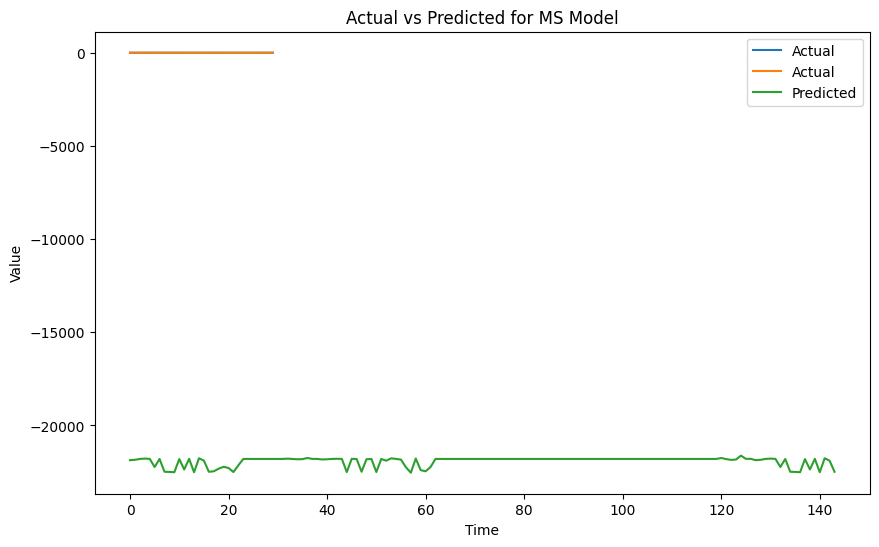

In [75]:
# Import matplotlib
import matplotlib.pyplot as plt

# Get the actual values
actual_ms = X_test_ms[-n_input:]

# Get the predicted values for each point in the test set
predicted_ms = []
for i in range(len(X_test_ms) - n_input):
    sequence = X_test_ms_scaled[i:i+n_input]
    sequence = np.reshape(sequence, (1, n_input, n_features_ms))
    prediction = loaded_model_ms.predict(sequence)
    predicted_ms.append(prediction[0])

# Create a line plot
plt.figure(figsize=(10,6))
plt.plot(actual_ms, label='Actual')
plt.plot(predicted_ms, label='Predicted')
plt.title('Actual vs Predicted for MS Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


1/1 [==============================] - 0s 21ms/step


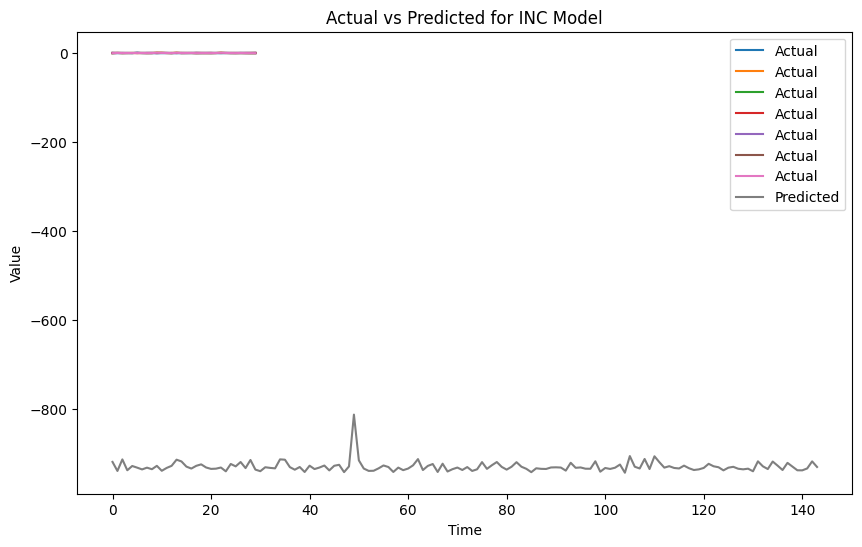

In [68]:
# Get the actual values
actual_inc = X_test_inc[-n_input:]

# Get the predicted values for each point in the test set
predicted_inc = []
for i in range(len(X_test_inc) - n_input):
    sequence = X_test_inc_scaled[i:i+n_input]
    sequence = np.reshape(sequence, (1, n_input, n_features_inc))
    prediction = loaded_model_inc.predict(sequence)
    predicted_inc.append(prediction[0])

# Create a line plot
plt.figure(figsize=(10,6))
plt.plot(actual_inc, label='Actual')
plt.plot(predicted_inc, label='Predicted')
plt.title('Actual vs Predicted for INC Model')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


In [69]:
# Flatten
actual_inc_flat = np.array(actual_inc).flatten()
predicted_inc_flat = np.array(predicted_inc).flatten()

# Ensure both arrays have the same length along axis 1
min_length = min(len(actual_inc_flat), len(predicted_inc_flat))
actual_inc_flat = actual_inc_flat[:min_length]
predicted_inc_flat = predicted_inc_flat[:min_length]

# Calculate correlation for INC model
correlation_inc = np.corrcoef(actual_inc_flat, predicted_inc_flat)[0, 1]
print("Correlation for INC model:", correlation_inc)


Correlation for INC model: -0.12400553017484275


In [70]:
# Flatten actual_ms and predicted_ms to 1D arrays
actual_ms_flat = np.array(actual_ms).flatten()
predicted_ms_flat = np.array(predicted_ms).flatten()

# Ensure both arrays have the same length
min_length = min(len(actual_ms_flat), len(predicted_ms_flat))
actual_ms_flat = actual_ms_flat[:min_length]
predicted_ms_flat = predicted_ms_flat[:min_length]

# Calculate correlation for MS model
correlation_ms = np.corrcoef(actual_ms_flat, predicted_ms_flat)[0, 1]
print("Correlation for MS model:", correlation_ms)


Correlation for MS model: -0.07157133503716358


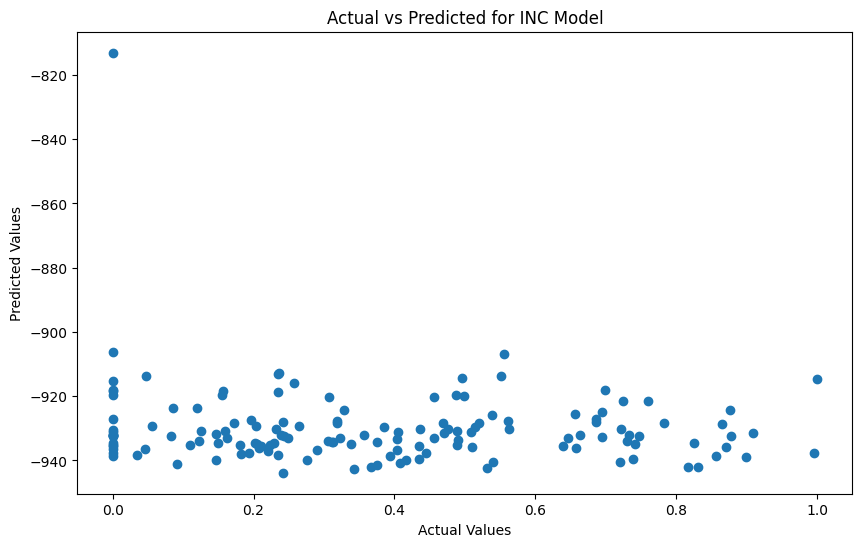

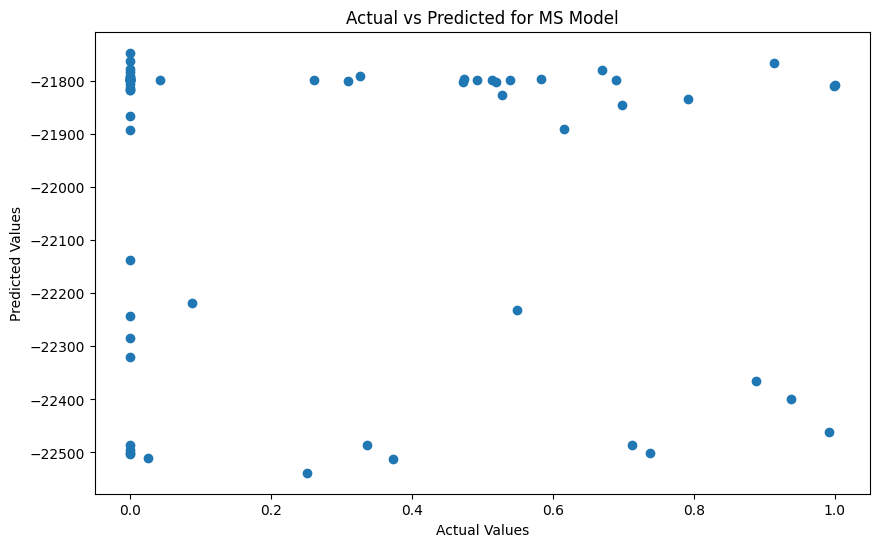

In [71]:
import matplotlib.pyplot as plt

# Scatter plot for INC model
plt.figure(figsize=(10,6))
plt.scatter(actual_inc_flat, predicted_inc_flat)
plt.title('Actual vs Predicted for INC Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Scatter plot for MS model
plt.figure(figsize=(10,6))
plt.scatter(actual_ms_flat, predicted_ms_flat)
plt.title('Actual vs Predicted for MS Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()
